In [191]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [360]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [407]:
# times when system is observed [years] relative to start of Gaia's observations (2456863.94 BJD)
ts=np.sort(edr3Period*(-0.5+np.random.rand(64)))

# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRA=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRA,params.pmDec)
params.pllx=10*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=10*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=5*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=10*(np.random.rand()**4)
params.l=np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

print('\nPeriod [years]: \n',astromet.period(params))

RA and Dec [degrees]: 
 197.4405904858132 76.40015159536414
Proper motion in RA and Dec [mas/yr]: 
 1.7905717788815982 9.909960613176645
Parallax [mas]: 
 6.138669294682407
Mass of brightest source [mSun]: 
 1.104325769200827
Semi-major axis [AU]: 
 1.1918305218733038
Eccentricity [dimensionless]: 
 0.7595596657043151
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.32251943018150164 0.3901932994194992
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 5.838010052891172 2.137264109880048
On-sky orientation angle of binary [radians]: 
 3.7906314655599753
Time of first binary periapse [years]: 
 0.9590970335617179

Period [years]: 
 1.0474666570992526


In [408]:
# on sky paths [degrees]
ras,decs=astromet.path(ts,params,t0=2)

# adding random (1/3 mas) error
astError=1
ras=ras+astError*mas*np.random.randn(ras.size)
decs=decs+astError*mas*np.random.randn(ras.size)

# fitting for offset from first obs (delta RA_0 & delta Dec_0), proper motion and parralax
fitParams,fitCovariance=astromet.fit(ts,ras,decs,obsError=astError,t0=2)
print('original parameters [mas]: \n',0,0,params.pmRA,params.pmDec,params.pllx)
print('derived parameters [mas]: \n',fitParams)
# extracting single parameter errors from covariance matrix
fitErrors=np.sqrt(np.diagonal(fitCovariance))/astError
print('derived parameter error [mas]: \n',fitErrors)
# note that parameters may not agree within error bars due to binary contribution

print('\ncovariance matrix [mas**2]: \n',fitCovariance)

'''
# mistake somewhere in this calibration
# ruwe is sqrt magnitude of covariance matrix normalised by error
uwe=np.sqrt(np.linalg.norm(fitCovariance))/astError
print('UWE [dimensionless]: \n',uwe)
'''


original parameters [mas]: 
 0 0 1.7905717788815982 9.909960613176645 6.138669294682407
derived parameters [mas]: 
 [ 8.06533468 23.92232147  1.97168397  9.97054695  6.11769377]
derived parameter error [mas]: 
 [0.37499739 0.37423157 0.15733682 0.1575455  0.04439447]

covariance matrix [mas**2]: 
 [[1.40623042e-01 8.38078489e-04 5.55380367e-02 3.53383313e-04
  1.52028138e-03]
 [8.38078489e-04 1.40049267e-01 1.56279430e-04 5.55719035e-02
  1.08647164e-03]
 [5.55380367e-02 1.56279430e-04 2.47548751e-02 6.58966235e-05
  2.83492191e-04]
 [3.53383313e-04 5.55719035e-02 6.58966235e-05 2.48205855e-02
  4.58120512e-04]
 [1.52028138e-03 1.08647164e-03 2.83492191e-04 4.58120512e-04
  1.97086862e-03]]


"\n# mistake somewhere in this calibration\n# ruwe is sqrt magnitude of covariance matrix normalised by error\nuwe=np.sqrt(np.linalg.norm(fitCovariance))/astError\nprint('UWE [dimensionless]: \n',uwe)\n"

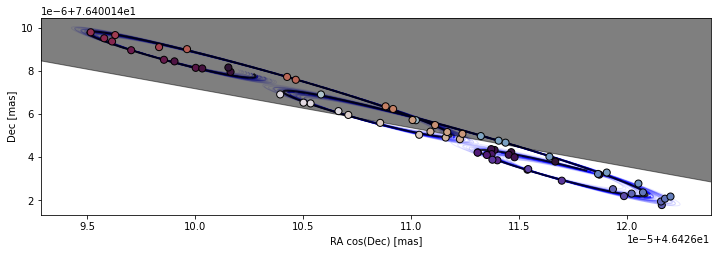

In [416]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot

deltaRas=(ras-ras[0])/mas # posn relative to first observation in mas
deltaDecs=(decs-decs[0])/mas
cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1])) # optional, but I like to color by time
qPl.scatter(ras*np.cos(decs*np.pi/180),decs,s=50,c=cs,zorder=2,edgecolors='k',lw=1)

# optional - adding the centre of mass motion (grey) for reference
tUniform=np.linspace(ts[0],ts[-1],1000)
comRas,comDecs=astromet.comPath(tUniform,params,t0=2)
#deltaComRas=(comRas-comRas[0])/mas
#deltaComDecs=(comDecs-comDecs[0])/mas
qPl.plot(comRas*np.cos(comDecs*np.pi/180),comDecs,lw=2,c='k',alpha=0.8,zorder=1)

# optional - adding fitted motion (blue)
for i in range(64):
    fitPs=astromet.params()
    fitPs.RA=np.median(ras)+mas*(fitParams[0]+fitErrors[0]*np.random.randn())
    fitPs.Dec=np.median(decs)+mas*(fitParams[1]+fitErrors[1]*np.random.randn())
    fitPs.pmRA=fitParams[2]+fitErrors[2]*np.random.randn()
    fitPs.pmDec=fitParams[3]+fitErrors[3]*np.random.randn()
    fitPs.pllx=fitParams[4]+fitErrors[4]*np.random.randn()
    bestRas,bestDecs=astromet.comPath(tUniform,fitPs,t0=2)
    #deltaBestRas=(bestRas-bestRas[0])/mas
    #deltaBestDecs=(bestDecs-bestDecs[0])/mas
    qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=1,c='b',alpha=0.1,zorder=0)
fitPs=astromet.params()
fitPs.RA=np.median(ras)+mas*fitParams[0]
fitPs.Dec=np.median(decs)+mas*fitParams[1]
fitPs.pmRA=fitParams[2]
fitPs.pmDec=fitParams[3]
fitPs.pllx=fitParams[4]
bestRas,bestDecs=astromet.comPath(tUniform,fitPs,t0=2)
qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=2,c='b',alpha=0.8,zorder=0,ls='--')

# adding initial position and proper motion as arrow
#qPl.arrow(np.median(ras*np.cos(decs*np.pi/180)),np.median(decs),mas*params.pmRA,mas*params.pmDec,color='k',alpha=0.5)

qPl.set_xlabel('RA cos(Dec) [mas]')
qPl.set_ylabel('Dec [mas]')
qPl.set_aspect('equal')

plt.show()